In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('combined_text_dataset.csv')
df.head()

,id,url,title,text,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens,label
0,17310494,https://en.wikipedia.org/wiki/Sekhukhune,Sekhukhune,Sekhukhune I (Matsebe; circa 1814 – 13 August ...,1,177,214,200 word wikipedia style introduction on 'Sekh...,"September 1881), also known as Sekhukhuni, wa...",35,282,0
1,762661,https://en.wikipedia.org/wiki/Mount%20Washingt...,Mount Washington (Olympics),Mount Washington is a peak in the Olympic Mou...,3,156,110,200 word wikipedia style introduction on 'Moun...,"the White Mountains of New Hampshire, in the ...",26,134,0
2,33838760,https://en.wikipedia.org/wiki/Acer%20hillsi,Acer hillsi,Acer hillsi is an extinct maple species in the...,2,291,110,200 word wikipedia style introduction on 'Acer...,that was endemic to the central Appalachian M...,25,136,0
3,2189174,https://en.wikipedia.org/wiki/Derrick%20Sherwin,Derrick Sherwin,Derrick George Sherwin (16 April 1936 – 9 Dece...,2,153,111,200 word wikipedia style introduction on 'Derr...,"9 December 2002) was an English actor, best k...",26,135,1
4,4124677,https://en.wikipedia.org/wiki/Windows%20shell,Windows shell,The Windows shell is the graphical user interf...,2,185,135,200 word wikipedia style introduction on 'Wind...,interface that provides a windowing environme...,22,147,1


In [3]:
data = df[['text', 'label']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    300000 non-null  object
 1   label   300000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


## Check the topics discussed in text data

In [86]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
from transformers import BertTokenizer, AdamW

# Load the stopwords and punctuation
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
punctuation_list = list(string.punctuation)

# Combine the stopwords and punctuation
filter_list = stopwords_list + punctuation_list

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the texts
texts = data['text'].tolist()
tokenized_texts = [tokenizer.tokenize(text) for text in texts]
all_tokens = [token for tokenized_texts in tokenized_texts for token in tokenized_texts]

# Remove stopwords and punctuation from the tokens
filtered_tokens = [token for token in all_tokens if token not in filter_list]

# Create a frequency table using Counter, and get the top 100 tokens
frequency_table = Counter(filtered_tokens)
top_100_tokens = frequency_table.most_common(100)
top_100_tokens_df = pd.DataFrame(top_100_tokens, columns=['token', 'count'])

print(top_100_tokens_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuanghongdeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      token   count
0       ##s  211016
1      also  169358
2      born  144820
3         –  132788
4     first  129135
..      ...     ...
95     town   29582
96  january   29355
97    based   29196
98    small   29043
99    house   28824

[100 rows x 2 columns]


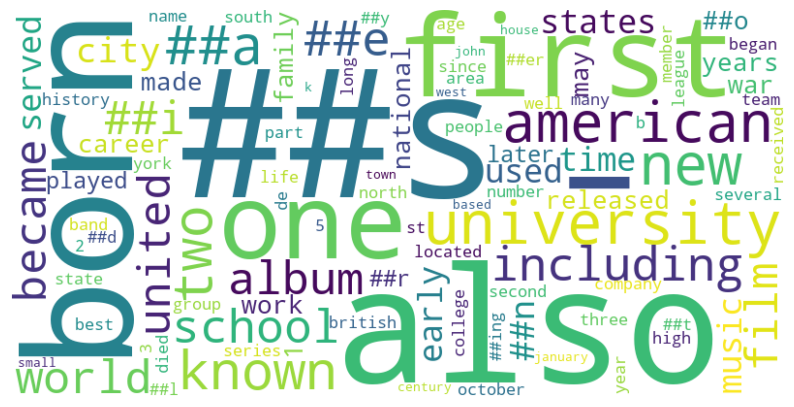

In [87]:
from wordcloud import WordCloud

token_freq_dict = top_100_tokens_df.set_index('token')['count'].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_freq_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Preprocessing for DistilBERT

In [6]:
import torch
import torchmetrics
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback

from transformers import DistilBertTokenizer
from transformers import get_scheduler
from transformers import AutoModelForSequenceClassification

In [88]:
# Load the fine-tuned model and the tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

token_lens = []

for text in data.text:
  tokens = tokenizer.encode(text, max_length = 512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


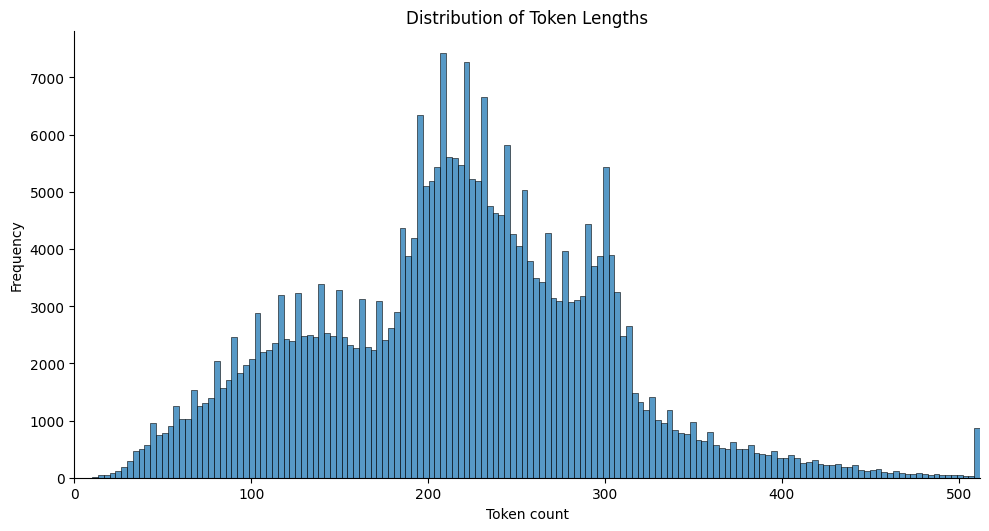

In [103]:
# Plot the distribution of token lengths
sns.displot(token_lens, height=5, aspect=2)

plt.title('Distribution of Token Lengths')
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.xlim([0, 512])

plt.show()

## DataLoader

In [8]:
from sklearn.model_selection import train_test_split

data_input = data.copy()

# data split
df_train, df_test = train_test_split(data_input, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [9]:
df_train.shape, df_val.shape, df_test.shape

((180000, 2), (60000, 2), (60000, 2))

In [10]:
class TextDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.label[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = 512,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            return_tensors = 'pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype = torch.long)
        }

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  dataset = TextDataset(
    text = df.text.to_numpy(),
    label = df.label.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
  )

  return DataLoader(dataset, batch_size = batch_size)

In [12]:
max_length = 512
batch_size = 8

train_data_loader = create_data_loader(df_train, tokenizer, max_length, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_length, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_length, batch_size)

len_train_data_loader = len(train_data_loader)

In [43]:
for i, batch in enumerate(train_data_loader):
    print(f"Batch {i+1}")
    print("Input IDs Shape:", batch['input_ids'].shape)
    print("Attention Mask Shape:", batch['attention_mask'].shape)
    print("Label Shape:", batch['label'].shape)
    print("Input IDs:", batch['input_ids'][0])

    break

Batch 1
Input IDs Shape: torch.Size([8, 512])
Attention Mask Shape: torch.Size([8, 512])
Label Shape: torch.Size([8])
Input IDs: tensor([  101,  3312, 11064,  7104,  1006,  2089,  2322,  1010,  6068,  1516,
         2285,  2385,  1010,  3261,  1007,  2001,  2019,  3493,  3166,  1998,
         2047,  2245,  2704,  1010,  9492,  1999,  7746,  2671,  1998,  3412,
         2671,  1012,  2220,  2166,  2852,  1012,  3312,  7104,  2001,  2141,
         1999,  3608, 18124,  6806,  2497,  1010,  2221,  8513,  1010,  3163,
         1010,  1996,  2365,  1997,  1037,  2797,  3337,  1005,  2082, 16296,
         1998,  2992,  1037,  3142,  3234,  1012,  2002,  2587,  1996, 20297,
         1012,  7104,  2001,  8302,  1999,  1996,  2120,  2082,  1998,  2001,
         6628,  2000,  2817,  2005,  1996, 17911,  1998,  2001,  3970,  2004,
         1037, 13840, 18014,  2937,  1012,  2174,  1010,  2011,  1996,  2051,
         2002,  2584,  2010,  2397,  9458,  2086,  1010,  2002,  2211,  2000,
         3160

## DistilBERT Model

In [55]:
# import the distilbert model

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

for param in model.parameters():
    param.requires_grad = False

# unfreeze the last layers
for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [126]:
# Model initialization

class LLMDetector(pl.LightningModule):
    def __init__(self, model, tokenizer, learning_rate=5e-5):
        super().__init__()

        self.model = model
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"],
                       attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        loss = outputs["loss"]
        logits = outputs["logits"]
        predicted_labels = torch.argmax(logits, 1)
        accuracy = self.train_acc(predicted_labels, batch["label"])

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {"loss": loss, "accuracy": accuracy}

    def validation_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        loss = outputs["loss"]
        logits = outputs["logits"]
        predicted_labels = torch.argmax(logits, 1)
        accuracy = self.val_acc(predicted_labels, batch["label"])

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
   
        return {"loss": loss, "accuracy": accuracy}

    def test_step(self, batch, batch_idx):
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"],
                       labels=batch["label"])
        loss = outputs["loss"]
        logits = outputs["logits"]
        predicted_labels = torch.argmax(logits, 1)
        accuracy = self.test_acc(predicted_labels, batch["label"])

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
        return {"loss": loss, "accuracy": accuracy}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        num_training_steps = len_train_data_loader * self.trainer.max_epochs

        scheduler = get_scheduler(
        "linear", optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
        )

        scheduler_config = {
            'scheduler': scheduler,
            'interval': 'step',  # updates after each batch
            'frequency': 1,
            'reduce_on_plateau': False
        }
        
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

lightning_model = LLMDetector(model, tokenizer)

In [17]:
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.metrics = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics

        # Append metrics
        self.metrics['train_loss'].append(metrics.get('train_loss', 0))
        self.metrics['train_acc'].append(train_acc = metrics.get('train_acc', 0))
        self.metrics['val_loss'].append(metrics.get('val_loss', 0))
        self.metrics['val_acc'].append(metrics.get('val_acc', 0))

callbacks = [
    ModelCheckpoint(
        monitor="val_acc", mode="max", save_top_k=1, verbose=True,
        dirpath='checkpoints/', filename='best-checkpoint-{epoch}-{val_acc:.2f}',
        auto_insert_metric_name=False
    ),
    MetricsCallback()
]

In [18]:
# Training

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=callbacks, # accelerator="gpu",
    devices=1,
    logger=False,
    log_every_n_steps=5
)

trainer.fit(model=lightning_model,
            train_dataloaders=train_data_loader,
            val_dataloaders=val_data_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type                                | Params
------------------------------------------------------------------
0 | model     | DistilBertForSequenceClassification | 67.0 M
1 | train_acc | MulticlassAccuracy                  | 0     
2 | val_acc   | MulticlassAccuracy                  | 0     
3 | test_acc  | MulticlassAccuracy                  | 0     
------------------------------------------------------------------
592 K     Trainable params
66.4 M    Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: Th

Training: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('train_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 22500: 'val_acc' reached 0.86690 (best 0.86690), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-0-0.87.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 45000: 'val_acc' reached 0.89262 (best 0.89262), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-1-0.89.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 67500: 'val_acc' reached 0.89503 (best 0.89503), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-2-0.90.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 90000: 'val_acc' reached 0.91792 (best 0.91792), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-3-0.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 112500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 135000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 157500: 'val_acc' reached 0.92403 (best 0.92403), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-6-0.92.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 180000: 'val_acc' reached 0.92935 (best 0.92935), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-7-0.93.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 202500: 'val_acc' reached 0.93155 (best 0.93155), saving model to '/Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-8-0.93.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 225000: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [116]:
checkpoint = torch.load('checkpoints/best-checkpoint-9-0.93.ckpt', map_location='cpu')
new_state_dict = {}

# Adjust the keys
for key, value in checkpoint['state_dict'].items():
    new_key = key.replace('model.model.', 'model.model.model.model.')
    new_state_dict[new_key] = value

# Replace the old state_dict
checkpoint['state_dict'] = new_state_dict

# Save the modified checkpoint if necessary
torch.save(checkpoint, 'checkpoints/modified-checkpoint.ckpt')

# Load the modified checkpoint
best_model = LLMDetector.load_from_checkpoint(
    'checkpoints/modified-checkpoint.ckpt',
    model=lightning_model,  
    tokenizer=tokenizer
)

best_model.load_state_dict(new_state_dict)
result = trainer.validate(best_model, dataloaders=val_data_loader)
print(result)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('val_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9315500259399414
        val_loss            0.16694895923137665
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'val_loss': 0.16694895923137665, 'val_acc': 0.9315500259399414}]


In [21]:
test_result = trainer.test(lightning_model, dataloaders=test_data_loader, ckpt_path="best")

test_loss = test_result[0]['test_loss']
test_acc = test_result[0]['test_acc']
print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.6f}")

Restoring states from the checkpoint path at /Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-8-0.93.ckpt
Loaded model weights from the checkpoint at /Users/shuanghongdeng/Documents/BT5153_Applied Machine Learning in Business Analytics/Group Project/checkpoints/best-checkpoint-8-0.93.ckpt
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/core/module.py:494: You called `self.log('test_acc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9325000047683716
        test_loss           0.16386723518371582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss: 0.163867, Test Accuracy: 0.932500


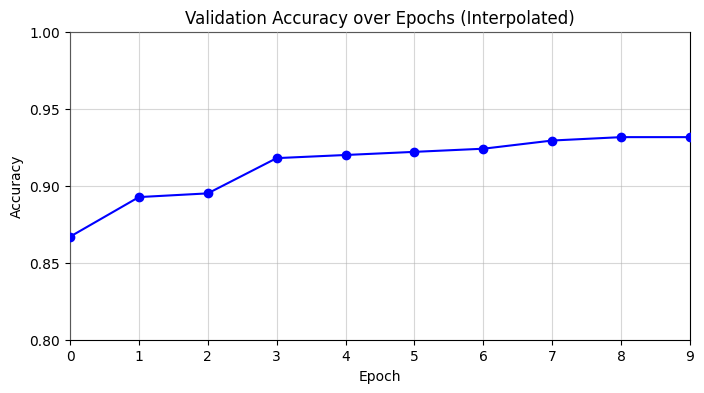

In [105]:
epoch = np.arange(10)

accuracy = [0.86690, 0.89262, 0.89503, 0.91792, np.nan, np.nan, 0.92403, 0.92935, 0.93155, np.nan]
# Interpolating missing values
accuracy_interpolated = pd.Series(accuracy).interpolate()

# Creating the plot
plt.figure(figsize=(8, 4))
plt.plot(epoch, accuracy_interpolated, marker='o', linestyle='-', color='b', zorder=3)

plt.title('Validation Accuracy over Epochs (Interpolated)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epoch)
plt.yticks(np.arange(0.8, 1.05, 0.05))
plt.ylim(0.8, 1)
plt.xlim(0, 9)

ax = plt.gca()
ax.set_axisbelow(False)

plt.grid(True, zorder = 0, alpha = 0.5)
plt.show()

In [131]:
new_text = "Overall, we reached a quite satisfying level of accuracy by fine-tuning the pre-trained DistilBERT model, with test and validation accuracy both exceeding 93%, indicating that our model generalizes well to new, unseen data and demonstrates robust performance across different subsets of the dataset. This shows that by capturing the context of words and understanding the sequence of words, the DistilBERT model can distinguish the differences between human-written and AI-generated texts."

inputs = tokenizer.encode_plus(new_text, add_special_tokens = True, return_tensors = "pt", return_attention_mask = True,
                               max_length = 512, padding = 'max_length', truncation=True)

# Predict
best_model.eval()
with torch.no_grad():  # Disable gradient computation
    dummy_labels = torch.zeros(inputs['input_ids'].size(0), dtype=torch.long).to(inputs['input_ids'].device)
    outputs = best_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=dummy_labels)
    predictions = outputs.logits.argmax(-1) 

# Convert logits to probabilities
probabilities = F.softmax(outputs.logits, dim=-1)

print(probabilities)

tensor([[0.9866, 0.0134]])


In [138]:
print(f'The probability that this paragraph is AI-generated is: {probabilities[0][1].item():.4f}')

The probability that this paragraph is AI-generated is: 0.0134
